# Time trials: peformance comparison of CNN architectures

## Vanilla convolutional neural network vs. depthwise separable convolutions

This is an experiment inspired by Francois Chollet's research into [depthwise separable convolutions](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728) ([video explanation](https://www.youtube.com/watch?v=T7o3xvJLuHk)), what's touted as being the next big thing in convolutional neural networks for super-accurate computer vision. Francois details the mechanics in [his paper](http://openaccess.thecvf.com/content_cvpr_2017/papers/Chollet_Xception_Deep_Learning_CVPR_2017_paper.pdf) detailing the [Xception](https://keras.io/applications/#xception) network, which ships with Keras.  

(I'm also curious how the [capsule network](https://en.wikipedia.org/wiki/Capsule_neural_network) crowd [feels about this](https://towardsdatascience.com/a-simple-and-intuitive-explanation-of-hintons-capsule-networks-b59792ad46b1).) 

For this test, I'm building networks to do binary image classification over a snapshot of [Kaggle's Dogs vs. Cats dataset](https://www.kaggle.com/c/dogs-vs-cats/data), using 1,000 images each of dogs and cats for the training set, and 500 images each for testing and validation hold-out sets. Data augmentation is applied in both approaches, with dropout regularization and appropriate pooling for downsampling.

While the layer architecture as laid out below isn't 100% comparable, there is a notable performance gain as far as training speed on smaller datasets, but negligible accuracy/loss. I need to test more with varying layer configurations and hyperparameter tuning. But what's inarguable is the massive reducuction in parameterization for the model: the first vanilla CNN uses around 651,000 weights, while the depthwise approach requires less than 71,000. Again, these are relatively simple models on a small number of training examples, but 10x is a significant improvement with respect to size. 

Also, the size of the models when serialized to disk is impressive: 7.6MB for the vanilla model vs. 606KB for the depthwise model.

Further experimentation needs to also consider transfer learning and fine-tuning via the pre-trained Xception network to gauge performance and accuracy - which might be odd since it was trained on ImageNet and not Dogs vs. Cats data.

In [22]:
import time
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

## Vanilla convolutional neural network architecture

In [9]:
model = Sequential()
model.add(Conv2D(32, 3, activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(256, 3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

train_generator = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_generator = ImageDataGenerator(rescale=1./255)

training_set = train_generator.flow_from_directory('./dogs_vs_cats/train/', target_size=(64, 64), batch_size=32, class_mode='binary')
testing_set = test_generator.flow_from_directory('./dogs_vs_cats/test/', target_size=(64, 64), batch_size=32, class_mode='binary')
validation_generator = test_generator.flow_from_directory('./dogs_vs_cats/validation/', target_size=(64, 64), batch_size=32, class_mode='binary')

start_time = time.time()

history = model.fit_generator(
    training_set,
    steps_per_epoch=80,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50)

end_time = time.time()

# save the model
model.save('dogs_vs_cats_classifier.h5')

print('Trained model in {:.2f} seconds'.format(end_time - start_time))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 4, 4, 256)         295168    
__________

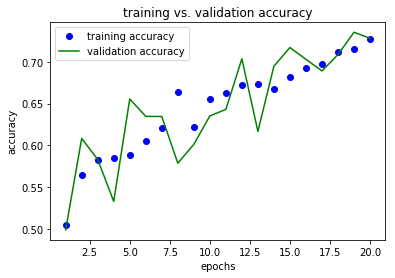

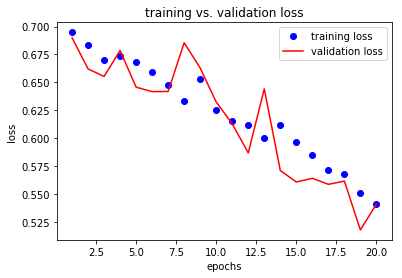

In [11]:
# plot the training evolution
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='training accuracy')
plt.plot(epochs, val_acc, 'g', label='validation accuracy')
plt.title('training vs. validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('training vs. validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

## Depthwise separable convolutions

In [20]:
model = Sequential()
model.add(SeparableConv2D(32, 3, activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(2))

model.add(SeparableConv2D(64, 3, activation='relu'))
model.add(SeparableConv2D(128, 3, activation='relu'))
model.add(MaxPooling2D(2))

model.add(SeparableConv2D(128, 3, activation='relu'))
model.add(SeparableConv2D(256, 3, activation='relu'))
model.add(GlobalAveragePooling2D())

model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


''' TIP: don't use a flattened layer; it throws an error about incompatiable dimension shapes '''

model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

train_generator = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_generator = ImageDataGenerator(rescale=1./255)

training_set = train_generator.flow_from_directory('./dogs_vs_cats/train/', target_size=(64, 64), batch_size=32, class_mode='binary')
testing_set = test_generator.flow_from_directory('./dogs_vs_cats/test/', target_size=(64, 64), batch_size=32, class_mode='binary')
validation_generator = test_generator.flow_from_directory('./dogs_vs_cats/validation/', target_size=(64, 64), batch_size=32, class_mode='binary')

start_time = time.time()

history = model.fit_generator(
    training_set,
    steps_per_epoch=80,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50)

end_time = time.time()

# save the model
model.save('dogs_vs_cats_classifier_depthwise_separable_cnn.h5')

print('Trained model in {:.2f} seconds'.format(end_time - start_time))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_31 (Separab (None, 62, 62, 32)        155       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
separable_conv2d_32 (Separab (None, 29, 29, 64)        2400      
_________________________________________________________________
separable_conv2d_33 (Separab (None, 27, 27, 128)       8896      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 13, 13, 128)       0         
_________________________________________________________________
separable_conv2d_34 (Separab (None, 11, 11, 128)       17664     
_________________________________________________________________
separable_conv2d_35 (Separab (None, 9, 9, 256)         34176     
__________

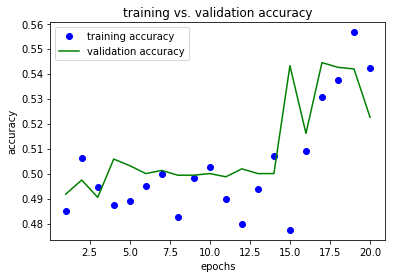

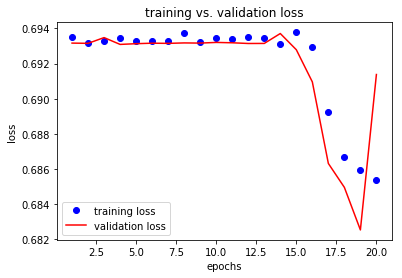

In [21]:
# plot the training evolution
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='training accuracy')
plt.plot(epochs, val_acc, 'g', label='validation accuracy')
plt.title('training vs. validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('training vs. validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()